In [38]:
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(
    style="whitegrid",
    rc={"figure.figsize": (7, 3.5)}
)

In [2]:
t1 = pd.read_csv('5_task_1.csv')
t2 = pd.read_csv('5_task_2.csv')

•	В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные   
•	Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый  
  
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

•	id – id клиента в эксперименте  
•	group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)  
•	events – сколько блюд суммарно было заказано за период  

In [3]:
t1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


•	id – id клиента в эксперименте  
•	segment – сегмент (high/low)  
•	group – вид кнопки (control – старая версия, test – новая версия)  
•	events – сколько блюд суммарно было заказано за период  

In [4]:
t2.head()   

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [5]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      30000 non-null  int64 
 1   group   30000 non-null  object
 2   events  30000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 703.3+ KB


In [6]:
t2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  int64  
 1   group    100000 non-null  object 
 2   segment  100000 non-null  object 
 3   events   100000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [7]:
t1.describe()

,id,events
count,30000.000000,30000.000000
mean,14999.500000,31.554500
std,8660.398374,10.878761
min,0.000000,-7.000000
25%,7499.750000,24.000000
50%,14999.500000,31.000000
75%,22499.250000,39.000000
max,29999.000000,75.000000


In [8]:
t2.describe()

,id,events
count,100000.000000,100000.000000
mean,49999.500000,34.213930
std,28867.657797,17.585193
min,0.000000,4.000000
25%,24999.750000,21.000000
50%,49999.500000,29.000000
75%,74999.250000,40.000000
max,99999.000000,102.000000


1.	Выберите метод, который предположительно подойдет в первом вопросе.

<Axes: xlabel='group', ylabel='events'>

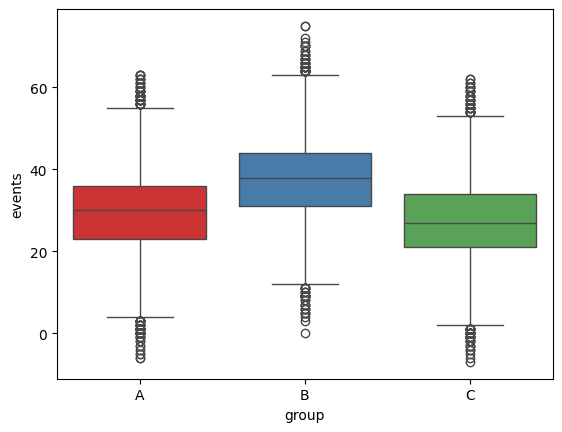

In [9]:
sns.boxplot(x="group", y="events", hue="group", data=t1, palette="Set1")

<Axes: xlabel='group', ylabel='events'>

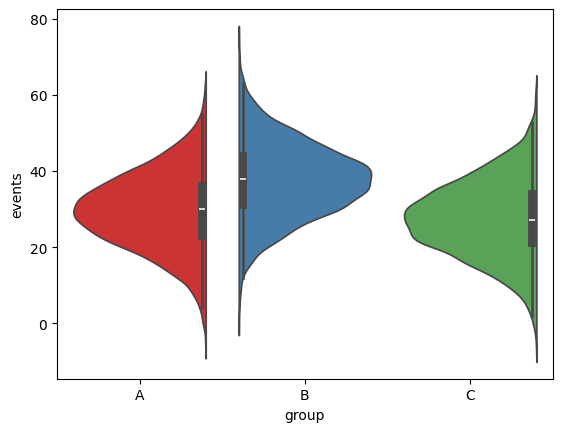

In [10]:
sns.violinplot(x="group", y="events", hue="group", data=t1, palette="Set1", split=True)

Каким статистическим методом нужно воспользоваться для сравнения вредних в данном случае?

In [18]:
# t1 ANOVA оneway(однофакторный), т.к. независимая переменная - группа (3 уровня: A, B, C), зависимая - события (events)

Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена. 

In [12]:
pg.homoscedasticity(data=t1, dv="events", group="group")
# p-value>0.05, значит гомоскедастичность выполняется, дисперсии в группах равны (не отвергаем H0(равенство дисперсий))

,W,pval,equal_var
levene,2.26226,0.104133,True


Убедитесь, что данные распределены нормально. Дополнительно сравните результат с qq графиками.

In [13]:
pg.normality(data=t1, dv="events", group="group", method="normaltest")
# p-value>0.05, значит нормальность выполняется (не отвергаем H0(распределение нормально))

,W,pval,normal
group,,,
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

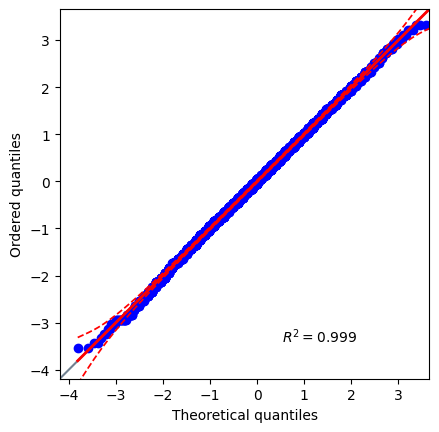

In [14]:
pg.qqplot(t1.query("group=='A'")["events"], dist='norm')

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

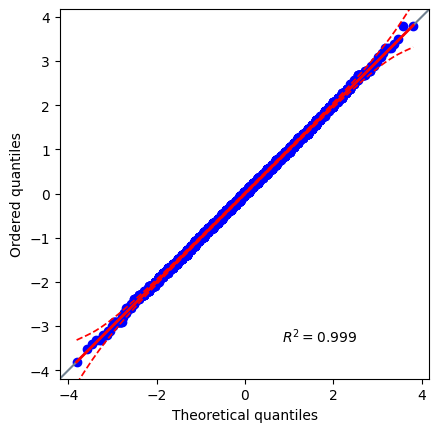

In [15]:
pg.qqplot(t1.query("group=='B'")["events"], dist='norm')    

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

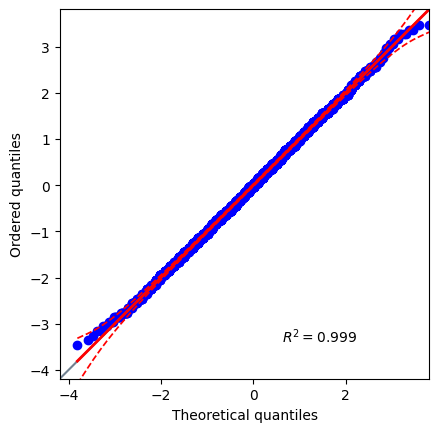

In [16]:
pg.qqplot(t1.query("group=='C'")["events"], dist='norm')

Однофакторный дисперсионный анализ

In [17]:
pg.anova(dv='events', between='group', data=t1)
# ddof1 - число степеней свободы между группами (dfbetween​=k−1, где k - число групп)
# ddof2 - число степеней свободы внутри групп, ошибка, шум (dfwithin​=N−k, где N - общее число наблюдений)
# F - значение критерия Фишера. Различия между средним числом заказанных блюд в группах в ~2900 раз сильнее, чем случайный шум внутри групп. 
# F = межгрупповые различия/внутригрупповые различия. F=MSbetween/MSwithin (эти значения можно получить, если ввести detailed=True)
# p-unc - p-value без поправки
# np2 - эффект размера Пирсона (>0.14 - большой эффект, 0.06-0.14 - средний, <0.06 - малый). Около 16% всей вариации пользовательского поведения объясняется именно разрешением фотографий
# вывод: p<0.05, отвергаем H0, значит есть статистически значимые различия между группами, np2=0.16 - большой эффект размера

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [25]:
st.f_oneway(t1.query("group=='A'")["events"],
          t1.query("group=='B'")["events"], 
          t1.query("group=='C'")["events"])
# вывод: p<0.05, отвергаем H0, значит есть статистически значимые различия между группами

F_onewayResult(statistic=np.float64(2886.166657438961), pvalue=np.float64(0.0))

Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия

In [26]:
#тьюки(делает поправку на множественные сравнения)
pg.pairwise_tukey(data=t1, dv="events", between="group")
# A, B - сравниваемые группы
# mean(A), mean(B) - средние значения в группах
# diff - разница между средними значениями групп
# se - стандартная ошибка разницы между средними
# t - значение t-критерия Стьюдента
# p-tukey - скорректированное p-значение с учетом множественных сравнений
# hedges - эффект размера Хеджеса
# вывод: между всеми группами есть статистически значимые различия потому что p-tukey<0.05

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.024138


In [33]:
# если не волнует равенство дисперсий, можно использовать метод Геймана-Хоуэлла
pg.pairwise_gameshowell(data=t1, dv="events", between="group")
# вывод: между всеми группами есть статистически значимые различия потому что p-adj<0.05

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,6.412648e-13,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.000000e+00,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.000000e+00,1.024138


In [34]:
# можно задать поправку вручную
pg.pairwise_ttests(data=t1, dv="events", between="group", padjust='bonf')
# вывод: между всеми группами есть статистически значимые различия потому что p-corr<0.05

c:\Users\911\AppData\Local\Programs\Python\Python313\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


In [27]:
multicomp = MultiComparison(t1['events'], t1['group'])
print(multicomp.tukeyhsd())
# вывод: между всеми группами есть статистически значимые различия потому что p-adj<0.05

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034   0.0   7.7038  8.3642   True
     A      C  -2.1093   0.0  -2.4395 -1.7791   True
     B      C -10.1433   0.0 -10.4735 -9.8131   True
----------------------------------------------------


Какие картинки в итоге нужно использовать?

Text(0, 0.5, 'Число покупок')

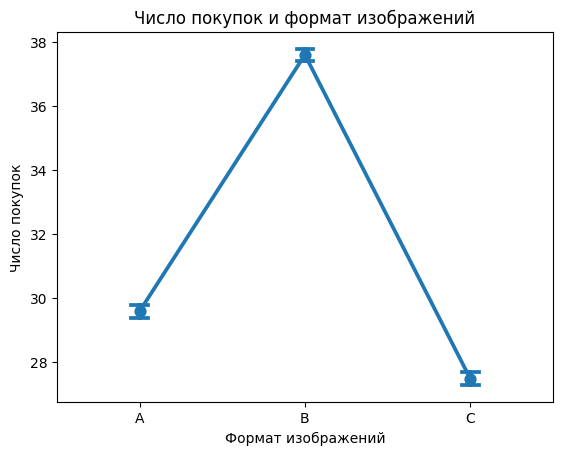

In [32]:
sns.pointplot(x='group', y='events', data=t1, capsize=.1)
plt.title('Число покупок и формат изображений')
plt.xlabel('Формат изображений')
plt.ylabel('Число покупок')

Во втором эксперименте требуется проверить, как пользователь отреагировал на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента

•	id – id клиента в эксперименте  
•	segment – сегмент (high/low)  
•	group – вид кнопки (control – старая версия, test – новая версия)  
•	events – сколько блюд суммарно было заказано за период  

In [35]:
t2.head()  

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


Какой метод нужно использовать в этом случае (t2)?

In [ ]:
# в случае t2 для сравнения нужно воспользоваться многофакторным ANOVA, т.к. факторов два: сегмент и вид кнопки

Визуализируйте распределение events для контрольной и тестовой группы

segment
high    Axes(0.125,0.11;0.775x0.77)
low     Axes(0.125,0.11;0.775x0.77)
Name: events, dtype: object

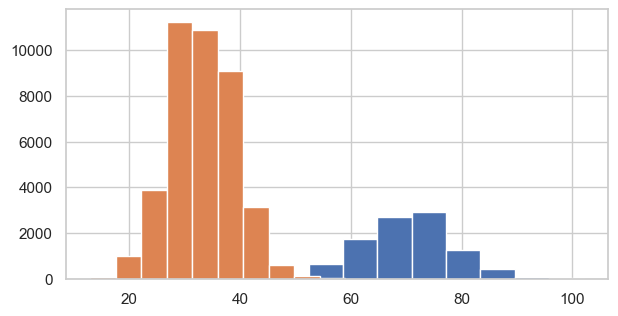

In [39]:
t2[t2['group']=='test'].groupby('segment')['events'].hist()

segment
high    Axes(0.125,0.11;0.775x0.77)
low     Axes(0.125,0.11;0.775x0.77)
Name: events, dtype: object

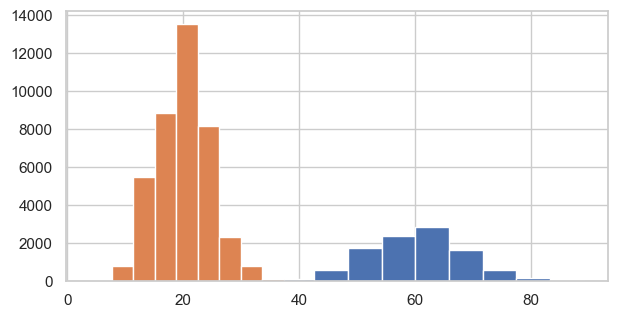

In [47]:
t2[t2['group']=='control'].groupby('segment')['events'].hist()

<Axes: xlabel='events', ylabel='Count'>

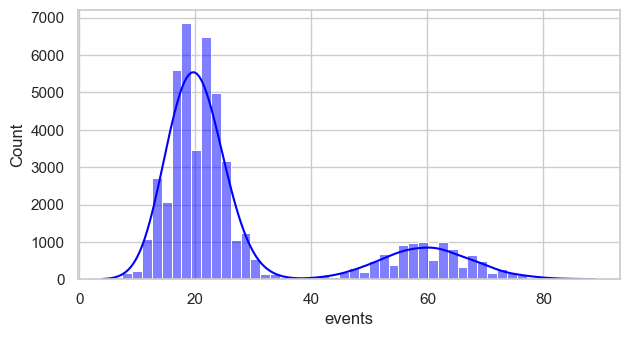

In [45]:
sns.histplot(x=t2.query("group=='control'")['events'], bins=50, kde=True, color='blue', label='control')

<Axes: xlabel='events', ylabel='Count'>

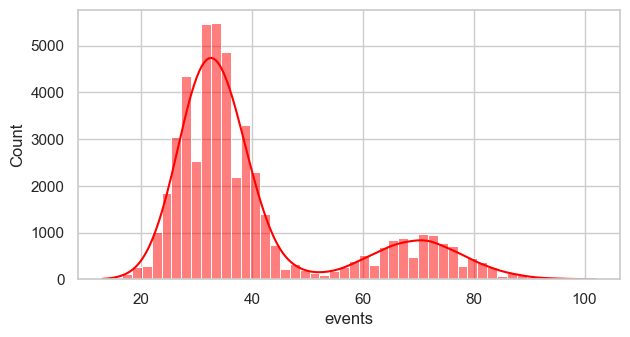

In [46]:
sns.histplot(x=t2.query("group=='test'")['events'], bins=50, kde=True, color='red', label='test')

Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 

In [49]:
t2.groupby(['group', 'segment'])['events'].describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

In [51]:
t2.groupby(['group', 'segment']).agg({'events': ['mean', 'median', 'std']}).round(2)

events             
                  mean median   std
group   segment                    
control high     59.97   60.0  7.81
        low      20.03   20.0  4.47
test    high     69.94   70.0  8.40
        low      33.03   33.0  5.72

Выберите формулу для модели, проведите тест. Испльзуйте критерий Тьюки, что бы понять между какими группами есть статистически значимые различия.

In [ ]:
# формула для модели: events ~ C(group) + C(segment) + C(group):C(segment)
# C() - указывает, что переменная категориальная
# ~ - означает, что мы моделируем зависимую переменную (слева) с помощью независимых переменных (справа)
# + означает, что мы включаем в модель основные эффекты для каждой независимой переменной
# C(group):C(segment) - взаимодействие между двумя факторами (:)

In [62]:
# statsmodels
model = smf.ols('events ~ C(group) + C(segment) + C(group):C(segment)', data=t2).fit()
anova_results = anova_lm(model)
aov_table = pd.DataFrame(anova_results)
aov_table.round(4)
# вывод: p<0.05 для всех факторов и взаимодействия, значит все факторы и их взаимодействие значимы

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,3.837195e+06,3.837195e+06,112031.8641,0.0
C(segment),1.0,2.362480e+07,2.362480e+07,689756.3775,0.0
C(group):C(segment),1.0,3.664244e+04,3.664244e+04,1069.8233,0.0
Residual,99996.0,3.424956e+06,3.425090e+01,NaN,NaN


In [63]:
# pingeouin
pg.anova(dv='events', between=['group', 'segment'], data=t2)
# вывод: p<0.05 для всех факторов и взаимодействия, значит все факторы и их взаимодействие значимы
# np2 (оказываемый эффект Пирсона) больше всего для сегмента, значит сегмент оказывает наибольшее влияние на число покупок
# np2 для взаимодействия небольшой, что означает что с точки зрения статистической значимости взаимодействие есть, но практически его влияние на результат невелико

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


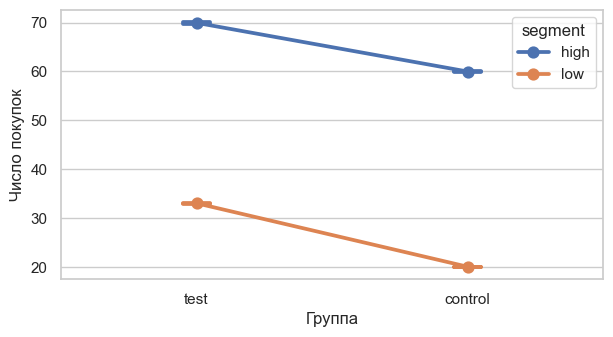

In [65]:
sns.pointplot(x='group', y='events', hue='segment', data=t2, capsize=.1)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

Text(0, 0.5, 'Число покупок')

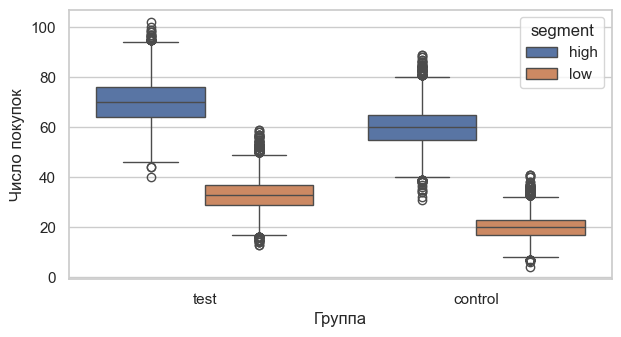

In [66]:
sns.boxplot(x='group', y='events', hue='segment', data=t2)
plt.xlabel('Группа')
plt.ylabel('Число покупок') 

In [68]:
# соединим колонки group и segment в один фактор для анализа, что бы передать в аргумент groups в MultiComparison либо pairwise_tukey
t2['group_segment'] = t2['group'] + '_' + t2['segment'] 
t2.head()

,id,group,segment,events,group_segment
0,83440,test,high,78.0,test_high
1,96723,test,high,71.0,test_high
2,68719,test,high,80.0,test_high
3,50399,test,high,80.0,test_high
4,95613,test,high,78.0,test_high


In [72]:
pg.pairwise_tukey(data=t2, dv='events', between='group_segment').round(3)
# вывод: между всеми парами групп есть статистически значимые различия потому что p-tukey<0.05

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control_high,control_low,59.971,20.032,39.939,0.065,610.391,0.0,7.522
1,control_high,test_high,59.971,69.938,-9.968,0.083,-120.433,0.0,-1.229
2,control_high,test_low,59.971,33.026,26.945,0.065,411.799,0.0,4.350
3,control_low,test_high,20.032,69.938,-49.907,0.065,-762.728,0.0,-9.091
4,control_low,test_low,20.032,33.026,-12.994,0.041,-314.003,0.0,-2.530
5,test_high,test_low,69.938,33.026,36.913,0.065,564.135,0.0,5.814
